In [2]:
!pip install ultralytics
!pip install supervision 

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 25.8 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.3 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.0 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 27.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 12.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 2.0 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 65.5 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.9.41
    Uninstalling nvidia-nvjitlink-cu12-12.9.41:
      Successfully uninstalled nvidia-nvjitlink-cu12-12.9.41
  Attempting uninstall: nvidia-curand-cu12
    Found existin

In [ ]:
import matplotlib.pyplot as plt
import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torchvision.transforms.functional import pil_to_tensor
import os
import torchvision.models as models
from sklearn.preprocessing import LabelEncoder

from huggingface_hub import hf_hub_download
from ultralytics import YOLO
from supervision import Detections

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [4]:
!cp /kaggle/input/face_embedding_model/pytorch/default/1/face_emb_model face_emb_model.pt

In [5]:
!cp /kaggle/input/eyes_detection_model/pytorch/eyes_model_v3/1/eyes_model_v3.pt face_keypoints_model.pt

In [6]:
class Resnet50ModelKeypoints(nn.Module):
    def __init__(self):
        super().__init__()
        resnet50 = models.resnet50(pretrained=True)
        self.conv_seq = nn.Sequential(*list(resnet50.children())[:-1])
        self.conv_seq[0] = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        
        self.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(2048, 12*2),
        )

    def forward(self, X):
        out_resnet = self.conv_seq(X).flatten(1)
        ans = self.fc(out_resnet)
        
        ans = F.sigmoid(ans)
        return ans.reshape(-1, 12, 2)


class Resnet101ModelEmbedding(nn.Module):
    def __init__(self):
        super().__init__()
        resnet101 = models.resnet101(weights=models.ResNet101_Weights.IMAGENET1K_V2) 
        self.conv_seq = nn.Sequential(*list(resnet101.children())[:-1], 
                                      nn.Flatten(),
                                      nn.Linear(2048, 512)
                                     )        
        
        self.weight = nn.Parameter(torch.Tensor(500, 512))
        nn.init.xavier_uniform_(self.weight)

    def forward(self, X, need_embeding=False):
        out = self.conv_seq(X)
        
        if torch.isnan(out).any():
           print("NaN found in out")
        
        weigth_norm = F.normalize(self.weight, p=2, dim=1)
        out_norm = F.normalize(out, p=2, dim=1)
        if (need_embeding == True):
            return out_norm
        return F.linear(out_norm, weigth_norm, bias=None)

        
face_keypoints_model = Resnet50ModelKeypoints()
face_keypoints_model.load_state_dict(torch.load('face_keypoints_model.pt', map_location=torch.device('cpu')))

face_emb_model = Resnet101ModelEmbedding()
face_emb_model.load_state_dict(torch.load('face_emb_model.pt', map_location=torch.device('cpu')))

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 137MB/s]
Downloading: "https://download.pytorch.org/models/resnet101-cd907fc2.pth" to /root/.cache/torch/hub/checkpoints/resnet101-cd907fc2.pth
100%|██████████| 171M/171M [00:01<00:00, 156MB/s] 


<All keys matched successfully>

In [70]:
!cp -r /kaggle/input/lfw-dataset/ .

In [9]:
!cp -r /kaggle/input/celeba-wild-subset/ .

In [11]:
class FaceAlignment():
    def __call__(self, img_tensor, left_center, right_center, img_h, img_w):
        dX = right_center[0] - left_center[0]
        dY = right_center[1] - left_center[1]
        angle = np.degrees(np.arctan2(dY, dX))

        desiredLeftEye = left_center / torch.tensor([img_h, img_w])
        
        
        dist = np.sqrt((dX ** 2) + (dY ** 2))
        desiredRightEyeX = desiredLeftEye[0] + dist / img_w
        # desiredRightEyeX = 1.0 - desiredLeftEye[0]
        
        desiredDist = (desiredRightEyeX - desiredLeftEye[0])
        
        desiredDist *= img_w
        scale = desiredDist / dist        

        eyesCenter = ((left_center[0] + right_center[0]) // 2, (left_center[1] + right_center[1]) // 2)
        eyesCenter = (eyesCenter[0].item(), eyesCenter[1].item())
        angle = angle.item()
        scale = max(scale.item(), -1)
        
        
        M = cv2.getRotationMatrix2D(eyesCenter, angle, scale)

        h, w = img_h, img_w
        output = cv2.warpAffine(img_tensor.permute(1, 2, 0).numpy(), M, (w, h), flags=cv2.INTER_CUBIC)
        
        return torch.from_numpy(output).permute(2, 0, 1)

In [ ]:
from PIL import Image
import torchvision.transforms as transforms

def get_face_embedding(path_to_image, need_plot = False):
    model_detection_path = hf_hub_download(repo_id="arnabdhar/YOLOv8-Face-Detection", filename="model.pt")
    detection_model = YOLO(model_detection_path)

    face_emb_model = Resnet101ModelEmbedding()
    face_emb_model.load_state_dict(torch.load('face_emb_model.pt', map_location=torch.device('cpu')))
    
    detection_transform = transforms.Compose([
        transforms.Resize((224, 224)),  
        transforms.ToTensor(),
    ])

    mean = torch.tensor([0.485, 0.456, 0.406])
    std = torch.tensor([0.229, 0.224, 0.225])
    
    img = Image.open(path_to_image).convert('RGB')
    orig_width, orig_height = img.size  
    
    input_tensor = detection_transform(img).unsqueeze(0)  
    
    detection_out = detection_model(input_tensor)
    detections = Detections.from_ultralytics(detection_out[0])
    
    if len(detections.xyxy) == 0:
        raise ValueError("No faces detected in the image")

    cnt = sum(detections.confidence >= 0.5)
    # print(detections)
    for i in range(len(detections.xyxy)):
        if (detections.confidence[i] < 0.5):
            continue
        detection_res = detections.xyxy[i]
    
        x_min, y_min, x_max, y_max = detection_res[:4]
        
        scale_x = orig_width / 224
        scale_y = orig_height / 224
        
        x_min_orig = int(x_min * scale_x)
        y_min_orig = int(y_min * scale_y)
        x_max_orig = int(x_max * scale_x)
        y_max_orig = int(y_max * scale_y)
        
        x_min_orig = max(0, x_min_orig)
        y_min_orig = max(0, y_min_orig)
        x_max_orig = min(orig_width, x_max_orig)
        y_max_orig = min(orig_height, y_max_orig)
        
        cropped_img = img.crop((x_min_orig, y_min_orig, x_max_orig, y_max_orig))

        img_tensor = detection_transform(cropped_img)
    
        face_keypoints_model = Resnet50ModelKeypoints()
        face_keypoints_model.load_state_dict(torch.load('face_keypoints_model.pt', map_location=torch.device('cpu')))
        face_keypoints_model.eval()

        face_embeddings = []
        if (need_plot):
            plt.figure(figsize=(8, 8))
        
        with torch.no_grad():
            crd = face_keypoints_model(img_tensor.unsqueeze(0))[0].detach().cpu().float()

            left_center = torch.mean(crd[:6].permute(1, 0), dim=1) * torch.tensor([img_tensor.shape[1], img_tensor.shape[2]])
            right_center = torch.mean(crd[6:].permute(1, 0), dim=1) * torch.tensor([img_tensor.shape[1], img_tensor.shape[2]])
            if (need_plot):
                plt.subplot(cnt, 2, 2*i+1)
                plt.imshow(img_tensor.permute(1, 2, 0))
                plt.scatter(crd[:,0] * img_tensor.shape[1], crd[:,1] * img_tensor.shape[2], s=10, c='red')
        
                plt.scatter(left_center[0], left_center[1], s=20, c='blue')
                plt.scatter(right_center[0], right_center[1], s=20, c='blue')
                
            face_align = FaceAlignment()
            aligned_img = face_align(img_tensor, left_center, right_center, img_tensor.shape[1], img_tensor.shape[2])
            if (need_plot):
                plt.subplot(cnt, 2, 2*i+2)
                plt.imshow(aligned_img.permute(1, 2, 0))

            aligned_img = torchvision.transforms.functional.normalize(aligned_img, mean, std)
            embedding = face_emb_model(aligned_img.unsqueeze(0))[0]
            face_embeddings.append((embedding, [x_min, y_min, x_max, y_max]))
        
        return face_embeddings


In [52]:
def cos_sim(a, b):
    dot_product = np.dot(a, b)
    norm_a = np.linalg.norm(a)
    norm_b = np.linalg.norm(b)
    if norm_a == 0 or norm_b == 0:
        return 0.0
    return dot_product / (norm_a * norm_b)


0: 224x224 1 FACE, 61.0ms
Speed: 0.0ms preprocess, 61.0ms inference, 1.9ms postprocess per image at shape (1, 3, 224, 224)

0: 224x224 1 FACE, 53.2ms
Speed: 0.0ms preprocess, 53.2ms inference, 1.6ms postprocess per image at shape (1, 3, 224, 224)

0: 224x224 1 FACE, 53.3ms
Speed: 0.0ms preprocess, 53.3ms inference, 1.8ms postprocess per image at shape (1, 3, 224, 224)


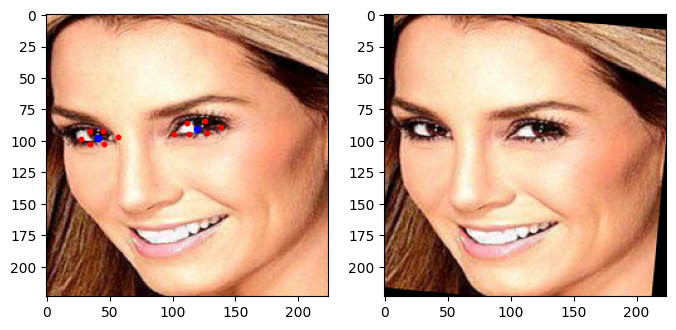

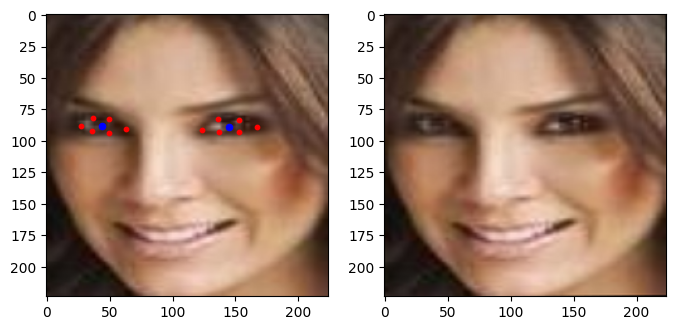

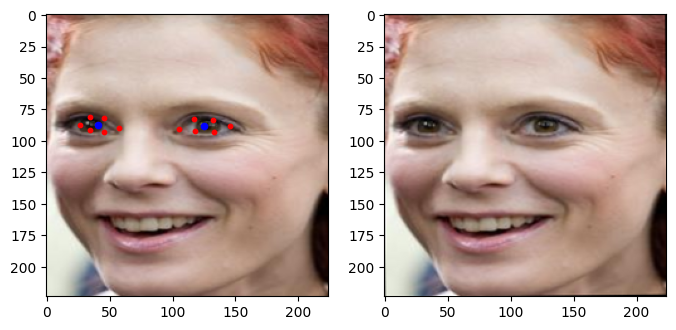

In [53]:
emb_1_1 = get_face_embedding('celeba-wild-subset/tmp_images/000001.jpg', need_plot=True)
emb_1_2 = get_face_embedding('celeba-wild-subset/tmp_images/000404.jpg', need_plot=True)
emb_2 = get_face_embedding('celeba-wild-subset/tmp_images/000002.jpg', need_plot=True)

In [54]:
print(cos_sim(emb_1_1[0][0], emb_1_2[0][0]), cos_sim(emb_1_1[0][0], emb_2[0][0]), cos_sim(emb_1_2[0][0], emb_2[0][0]))

0.19941421 -0.0013863962 0.13440342



0: 224x224 1 FACE, 42.9ms
Speed: 0.0ms preprocess, 42.9ms inference, 2.0ms postprocess per image at shape (1, 3, 224, 224)

0: 224x224 1 FACE, 47.6ms
Speed: 0.0ms preprocess, 47.6ms inference, 1.6ms postprocess per image at shape (1, 3, 224, 224)

0: 224x224 1 FACE, 41.5ms
Speed: 0.0ms preprocess, 41.5ms inference, 1.7ms postprocess per image at shape (1, 3, 224, 224)


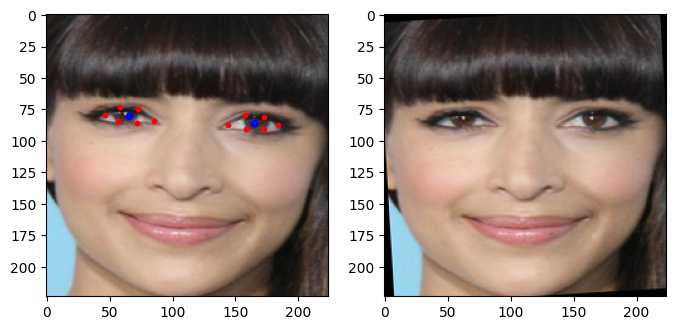

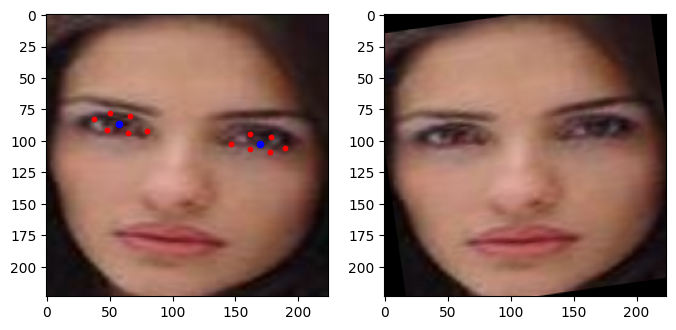

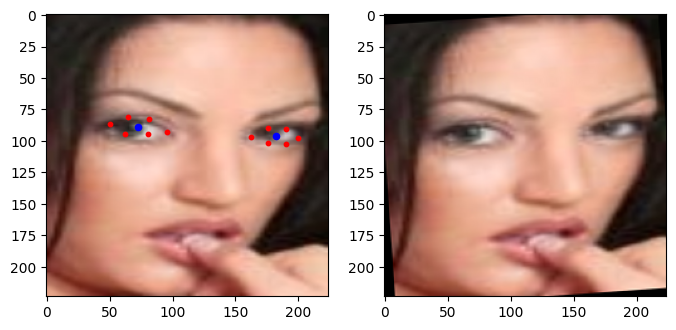

In [65]:
emb_121 = get_face_embedding('celeba-wild-subset/tmp_images/000121.jpg', need_plot=True)

emb_10046_1 = get_face_embedding('celeba-wild-subset/tmp_images/000026.jpg', need_plot=True)
emb_10046_2 = get_face_embedding('celeba-wild-subset/tmp_images/001042.jpg', need_plot=True)

In [66]:
print(cos_sim(emb_10046_1[0][0],emb_10046_2[0][0]), cos_sim(emb_121[0][0],emb_10046_1[0][0]), cos_sim(emb_121[0][0],emb_10046_2[0][0]))

0.3057959 0.15992576 0.14957398



0: 224x224 1 FACE, 48.7ms
Speed: 0.0ms preprocess, 48.7ms inference, 2.0ms postprocess per image at shape (1, 3, 224, 224)

0: 224x224 1 FACE, 40.7ms
Speed: 0.0ms preprocess, 40.7ms inference, 1.7ms postprocess per image at shape (1, 3, 224, 224)

0: 224x224 1 FACE, 40.0ms
Speed: 0.0ms preprocess, 40.0ms inference, 1.7ms postprocess per image at shape (1, 3, 224, 224)


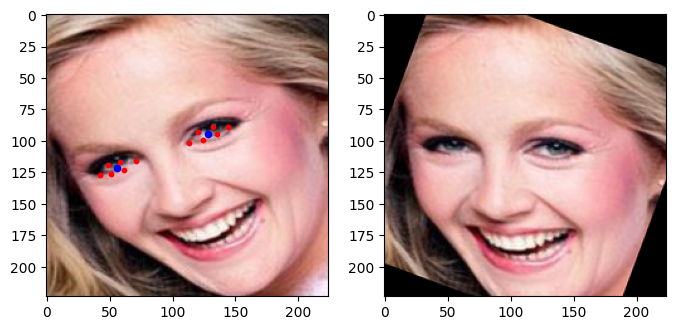

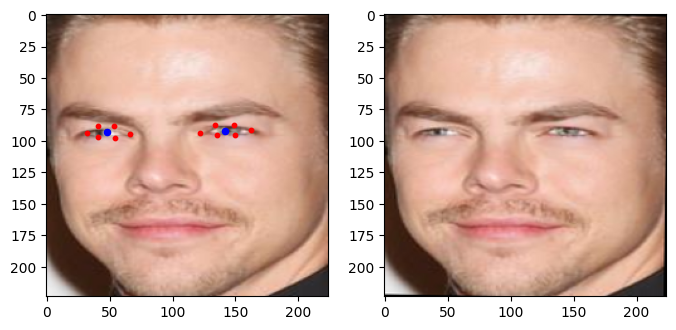

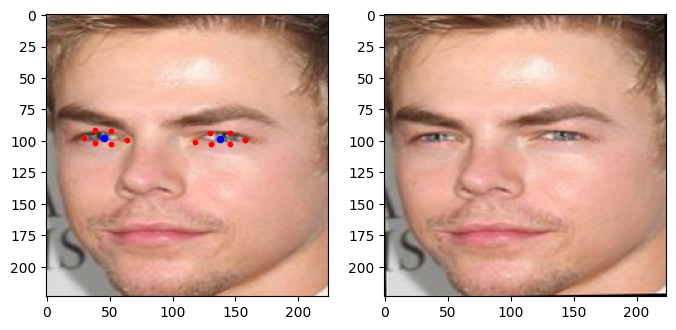

In [67]:
emb_1212 = get_face_embedding('celeba-wild-subset/tmp_images/001212.jpg', need_plot=True)

emb_2507_1 = get_face_embedding('celeba-wild-subset/tmp_images/001897.jpg', need_plot=True)
emb_2507_2 = get_face_embedding('celeba-wild-subset/tmp_images/001047.jpg', need_plot=True)

In [69]:
print(cos_sim(emb_2507_1[0][0],emb_2507_2[0][0]), cos_sim(emb_2507_1[0][0],emb_1212[0][0]), cos_sim(emb_2507_2[0][0],emb_1212[0][0]))

0.38638577 0.1703509 -0.005291564


In [72]:
!ls
!rm -rf celeba-wild-subset
!rm -rf lfw-dataset
!rm face_emb_model.pt  face_keypoints_model.pt

celeba-wild-subset  face_emb_model.pt  face_keypoints_model.pt	lfw-dataset
